# 1. Importing Libraries and Data

In [1]:
import pandas as pd
from datetime import date, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from IPython.display import display
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO 
from subprocess import call

import warnings
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.regularizers import l2

from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
# from deslib.static.stacked import StackedClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.ensemble import StackingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import tree
from sklearn.tree import export_graphviz
from pickle import dump

from Classes import Classification
from Classes import Ensemble

pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

/Users/ravimalde/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.


In [2]:
df = pd.read_csv('data_cleaned6.csv')

In [4]:
df.drop(columns=['fight_time_x','fight_time_y'], inplace=True)

In [5]:
df

,height_x,weight_x,reach_x,fx_win,age_x,str_landed_per_min_x,str_acc_x,str_absorb_per_min_x,str_def_x,td_avg_x,td_acc_x,td_def_x,sub_avg_x,win_percentage_x,height_y,weight_y,reach_y,age_y,str_landed_per_min_y,str_acc_y,str_absorb_per_min_y,str_def_y,td_avg_y,td_acc_y,td_def_y,sub_avg_y,win_percentage_y
0,1.75,135.0,1.78,0,25.05,7.27,0.80,6.33,0.74,0.00,0.00,0.62,1.00,0.89,1.78,135.0,1.78,27.63,2.52,0.26,9.71,0.59,0.00,0.00,1.00,0.00,0.80
1,1.73,155.0,1.75,0,25.10,6.20,0.55,5.80,0.49,0.00,0.00,0.75,1.00,0.72,1.70,155.0,1.78,29.69,2.26,0.48,8.64,0.62,1.54,0.50,1.00,4.63,0.85
2,1.73,155.0,1.75,1,27.93,5.50,0.54,5.85,0.48,1.50,0.29,0.75,0.75,0.70,1.70,155.0,1.75,31.81,5.80,0.50,5.80,0.50,1.00,0.50,0.50,0.00,0.64
3,1.73,155.0,1.75,1,28.66,6.91,0.52,5.96,0.45,1.26,0.38,0.58,0.42,0.69,1.75,155.0,1.78,24.69,6.85,0.42,6.85,0.42,0.00,0.00,0.00,0.00,0.78
4,1.73,155.0,1.75,1,29.47,7.68,0.53,6.10,0.50,1.11,0.38,0.11,0.00,0.68,1.73,155.0,1.73,26.77,1.39,0.24,4.17,0.58,0.00,0.00,1.00,0.00,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3931,1.78,125.0,1.80,0,27.35,2.26,0.49,2.46,0.51,3.56,0.32,0.22,1.78,0.79,1.63,125.0,1.65,32.10,4.70,0.51,4.70,0.51,5.53,0.33,0.33,0.85,0.70
3932,1.83,185.0,1.88,1,34.35,1.89,0.60,1.89,0.60,0.00,0.00,0.00,1.23,0.46,1.78,170.0,1.85,36.02,4.07,0.39,4.07,0.39,2.69,0.80,0.80,0.34,0.81
3933,1.55,115.0,1.60,0,24.82,4.71,0.46,4.71,0.46,0.33,1.00,1.00,0.33,0.86,1.65,115.0,1.60,29.02,7.07,0.48,7.07,0.48,0.00,0.00,0.00,0.00,0.89
3934,1.80,135.0,1.75,0,27.40,7.03,0.32,7.03,0.32,0.00,0.00,0.00,0.00,0.73,1.70,135.0,1.73,32.53,2.77,0.38,2.77,0.38,1.54,0.33,0.33,0.00,0.65


# 2. Data Transformations

In [6]:
y = df[['fx_win']]

In [7]:
X = df.drop(columns=['fx_win'])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=400, random_state=50)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=50)

In [9]:
x_cols = [col for col in X.columns if '_x' in col]
y_cols = [col for col in X.columns if '_y' in col]

In [12]:
scaler = StandardScaler()

In [15]:
X_train[x_cols] = scaler.fit_transform(X_train[x_cols])
X_train[y_cols] = scaler.transform(X_train[y_cols])

In [19]:
X_val[x_cols] = scaler.transform(X_val[x_cols])
X_val[y_cols] = scaler.transform(X_val[y_cols])

In [20]:
X_test[x_cols] = scaler.transform(X_test[x_cols])
X_test[y_cols] = scaler.transform(X_test[y_cols])

In [22]:
dump(scaler, open('scaler.pkl', 'wb'))

# 3. Modelling

In [23]:
skf = StratifiedKFold(n_splits=5, random_state=50)

## 3.1. Logistic Regression

In [25]:
log_reg1 = Classification("Logistic Regression", X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Logistic Regression,0.658358,0.612182


The best hyperparameters are:  {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'} 



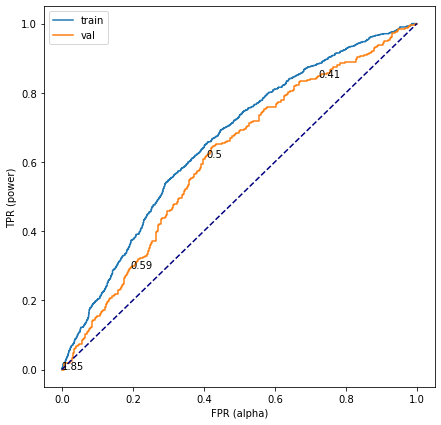

In [26]:
param_grid = {'C': [0.01,0.1,1,10,100],
             'penalty': ['l1','l2'],
             'solver': ['liblinear','saga']}
log_reg1.get_scores(param_grid, skf)

## 3.2. Support Vector Machine

In [27]:
svm1 = Classification("SVM", X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,SVM,0.835662,0.674616


The best hyperparameters are:  {'C': 1, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'scale'} 



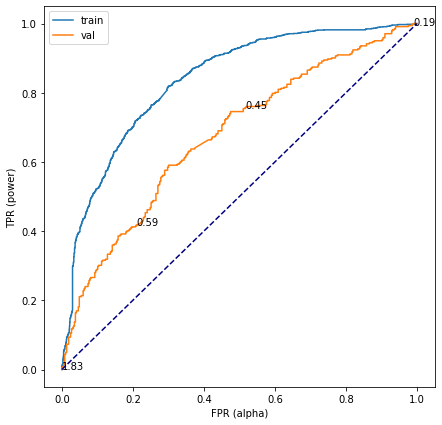

In [28]:
param_grid = {'C':[1,2,3,4,5,6],
             'degree':[1,2,3,4,5,6],
             'gamma':['scale','auto'],
             'decision_function_shape':['ovo','ovr']}
svm1.get_scores(param_grid, skf)

## 3.3. Decision Tree

In [ ]:
d_tree = Classification('Decision Tree', X_train_s, X_val_s, y_train, y_val)

In [ ]:
param_grid = {'max_depth':[1,10,100,1000],'min_samples_leaf':[1,10,100,1000]}
d_tree.get_scores(param_grid, skf)

In [ ]:
d_tree.opt_plots()

In [ ]:
d_tree2 = Classification('Decision Tree', X_train_s, X_val_s, y_train, y_val)

In [ ]:
param_grid = {'max_depth':range(0,106,5),'min_samples_leaf':range(50,155,5)}
d_tree2.get_scores(param_grid, skf)

In [ ]:
d_tree2.opt_plots()

In [ ]:
d_tree3 = Classification('Decision Tree', X_train_s, X_val_s, y_train, y_val)

In [ ]:
param_grid = {'max_depth':range(1,11,1),'min_samples_leaf':range(25,51,1)}
d_tree3.get_scores(param_grid, skf)

In [ ]:
d_tree3.opt_plots()

## 3.4. Random Forest

In [40]:
rand_forr = Classification("Random Forest", X_train_s, X_val_s, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Random Forest,0.988122,0.654611


The best hyperparameters are:  {'max_depth': 10, 'min_samples_leaf': 1} 



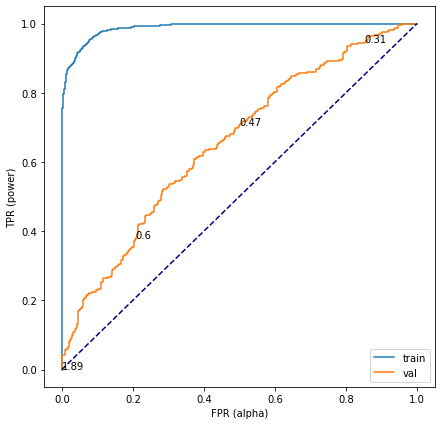

In [41]:
param_grid = {'max_depth':[1,10,100,1000],'min_samples_leaf':[1,10,100,1000]}
rand_forr.get_scores(param_grid, skf)

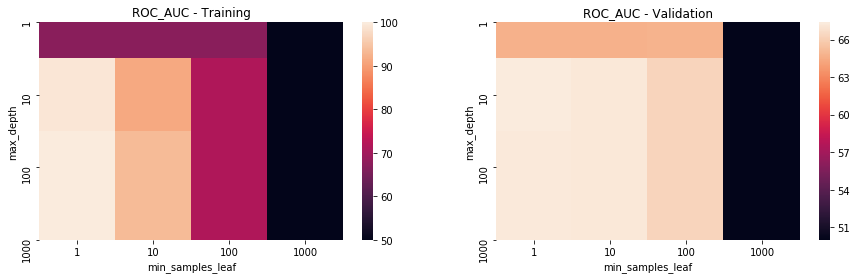

In [42]:
rand_forr.opt_plots()

In [31]:
rand_forr2 = Classification("Random Forest", X_train, X_val, y_train, y_val)

,Model,Train AUC,Validation AUC
0,Random Forest,0.999999,0.672866


The best hyperparameters are:  {'max_depth': 16, 'min_samples_leaf': 2} 



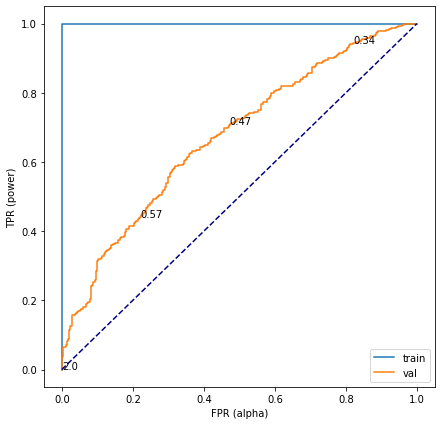

In [32]:
param_grid = {'max_depth':range(10,21,1),'min_samples_leaf':range(1,11,1)}
rand_forr2.get_scores(param_grid, skf)

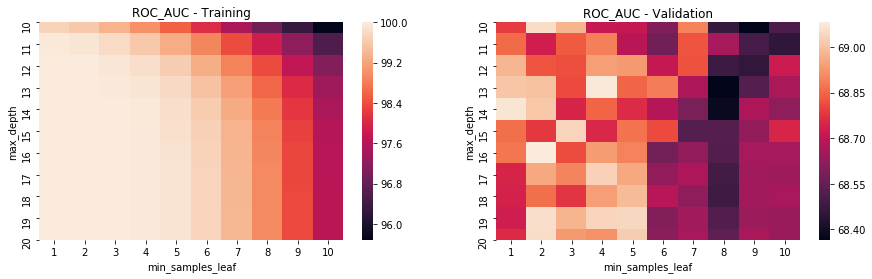

In [33]:
rand_forr2.opt_plots()

## 3.5. Voing Classifier

In [ ]:
log_reg = ('lr', log_reg1.best_model)
svm = ('svm', svm1.best_model)
# d_tree = ('d_tree', d_tree3.best_model)
rand_forr = ('rand_forr', rand_forr2.best_model)
estimators = [log_reg, svm, rand_forr]
voting = Ensemble("Voting", estimators, X_train_s, X_val_s, y_train, y_val)

In [ ]:
voting.ensemble_get_scores({}, skf)

## 3.6. Adaboost

In [ ]:
estimators = log_reg1.best_model
adaboost1 = Ensemble("AdaBoost", estimators, X_train_s, X_val_s, y_train, y_val)

In [ ]:
# adaboost1.ensemble_get_scores({}, skf)

In [ ]:
estimators = svm1.best_model
adaboost2 = Ensemble("AdaBoost", estimators, X_train_s, X_val_s, y_train, y_val)

In [ ]:
adaboost2.ensemble_get_scores({}, skf)

In [ ]:
estimators = rand_forr2.best_model
adaboost3 = Ensemble("AdaBoost", estimators, X_train_s, X_val_s, y_train, y_val)

In [ ]:
adaboost3.ensemble_get_scores({}, skf)

## 3.7. XGBoost

In [ ]:
estimators = []
xgboost = Ensemble("XGBoost", estimators, X_train, X_val, y_train, y_val)

In [ ]:
xgboost.ensemble_get_scores({}, skf)

## 3.8. Stacking Classifier

In [ ]:
estimators = [('lr',log_reg1.best_model), 
              ('svm', svm1.best_model), 
              ('rnd', rand_forr2.best_model)]
stacking = Ensemble("Stacking", estimators, X_train, X_val, y_train, y_val)

In [ ]:
stacking.ensemble_get_scores({}, skf)

In [ ]:
stacking.best_model

In [ ]:
voting.best_model.score(X_val_s, y_val)

In [ ]:
stacking.best_model.score(X_val_s, y_val)

In [ ]:
rand_forr2.best_model.score(X_val_s, y_val)

In [ ]:
log_reg1.best_model.score(X_val_s, y_val)

In [ ]:
l2_reg = keras.regularizers.l2(0.0001)

In [ ]:
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_dim=X_train_s.shape[1], kernel_initializer='normal', 
                 kernel_regularizer=l2_reg))
model2.add(Dropout(rate=0.1))
model2.add(Dense(64, activation='relu', kernel_initializer='normal', kernel_regularizer=l2_reg))
model2.add(Dropout(rate=0.1))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.summary()

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(X_train_s, y_train, epochs=40, batch_size=16, validation_data=(X_val_s, y_val))

In [ ]:
pd.DataFrame(history2.history).plot(figsize=(15,10))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
y_pred = model2.predict(X_test_s)

In [ ]:
model2.evaluate(X_val_s, y_val)

In [34]:
dump(rand_forr2.best_model, open('model.pkl', 'wb'))